# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from time import time


# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
# pd.options.display.height = 1000
pd.options.display.max_rows = 1000
pd.options.display.width = 1000

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customer = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [6]:
azdias.to_csv('AZDIAS_052018.csv',header=True)

In [7]:
customer.to_csv('CUSTOMERS_052018.csv',header=True)

In [33]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [34]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [35]:
customer.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [36]:
# Drop the three columns unneeded in customer dataset
customer.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs

In [37]:
# Load in the feature summary file.
feat_info = pd.read_csv('DIAS Attributes - Values 2017_final.csv',delimiter=',')

In [38]:
feat_info.head()

,attribute,type,meaning,missing_or_unknown
0,AGER_TYP,categorical,unknown,[-1]
1,ALTERSKATEGORIE_GROB,categorical,unknown,"[-1, 0]"
2,ALTER_HH,interval,unknown / no main age detectable,[0]
3,ANREDE_KZ,categorical,unknown,"[-1, 0]"
4,BALLRAUM,ordinal,unknown,[-1]


In [39]:
# Set attribute as index for `feat_info` dataframe
feat_info.set_index('attribute', inplace=True)

In [40]:
# Delete columns found in the features not found in the general population dataframe
feat_info_missing = np.setdiff1d(feat_info.index, azdias.columns, assume_unique=True)

In [41]:
azdias_missing = np.setdiff1d(azdias.columns, feat_info.index, assume_unique=True)

In [42]:
feat_info.drop(feat_info_missing, inplace=True)

In [43]:
azdias.drop(azdias_missing,axis=1, inplace=True)

In [44]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 237 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(195), int64(40), object(2)
memory usage: 1.6+ GB


In [45]:
azdias.head()

,AGER_TYP,ALTER_HH,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,2.0,0,0,NaN,0,0,...,1,-1,NaN,-1,NaN,NaN,NaN,3,1,2
1,-1,0.0,6.0,8,5.0,0,0,NaN,0,0,...,1,3,0.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,2.0,4,3.0,0,0,0.0,0,0,...,4,2,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,4.0,2,2.0,0,0,0.0,0,0,...,4,1,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,2.0,6,5.0,3,5,10.0,6,6,...,7,2,0.0,2,2.0,9.0,3.0,4,1,3


In [46]:
feat_info.reset_index(inplace=True)

In [47]:
feat_info.head()

,attribute,type,meaning,missing_or_unknown
0,AGER_TYP,categorical,unknown,[-1]
1,ALTERSKATEGORIE_GROB,categorical,unknown,"[-1, 0]"
2,ALTER_HH,interval,unknown / no main age detectable,[0]
3,ANREDE_KZ,categorical,unknown,"[-1, 0]"
4,BALLRAUM,ordinal,unknown,[-1]


In [48]:
feat_info['missing_or_unknown'].value_counts(dropna=False)

[0]        97
[-1]       69
[-1, 9]    58
[-1, 0]     8
[10]        5
Name: missing_or_unknown, dtype: int64

In [49]:
start = time()

In [50]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

KeyboardInterrupt: 

In [ ]:
for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_or_unknown[0] == '':
        azdias[attribute] = azdias[attribute].replace('',np.nan)
  
    elif len(missing_or_unknown) > 1:
        for each in missing_or_unknown:
            each = int(each)
            azdias.loc[azdias[attribute] == each, [attribute]] = np.nan
    else:
        for each in missing_or_unknown:
            each = int(each)
            azdias.loc[azdias[attribute] == each, [attribute]] = np.nan

In [ ]:
end = time()

In [ ]:
print(round(end-start,3))

In [ ]:
azdias.head()

#### Step 1.1.2: Assess Missing Data in Each Column

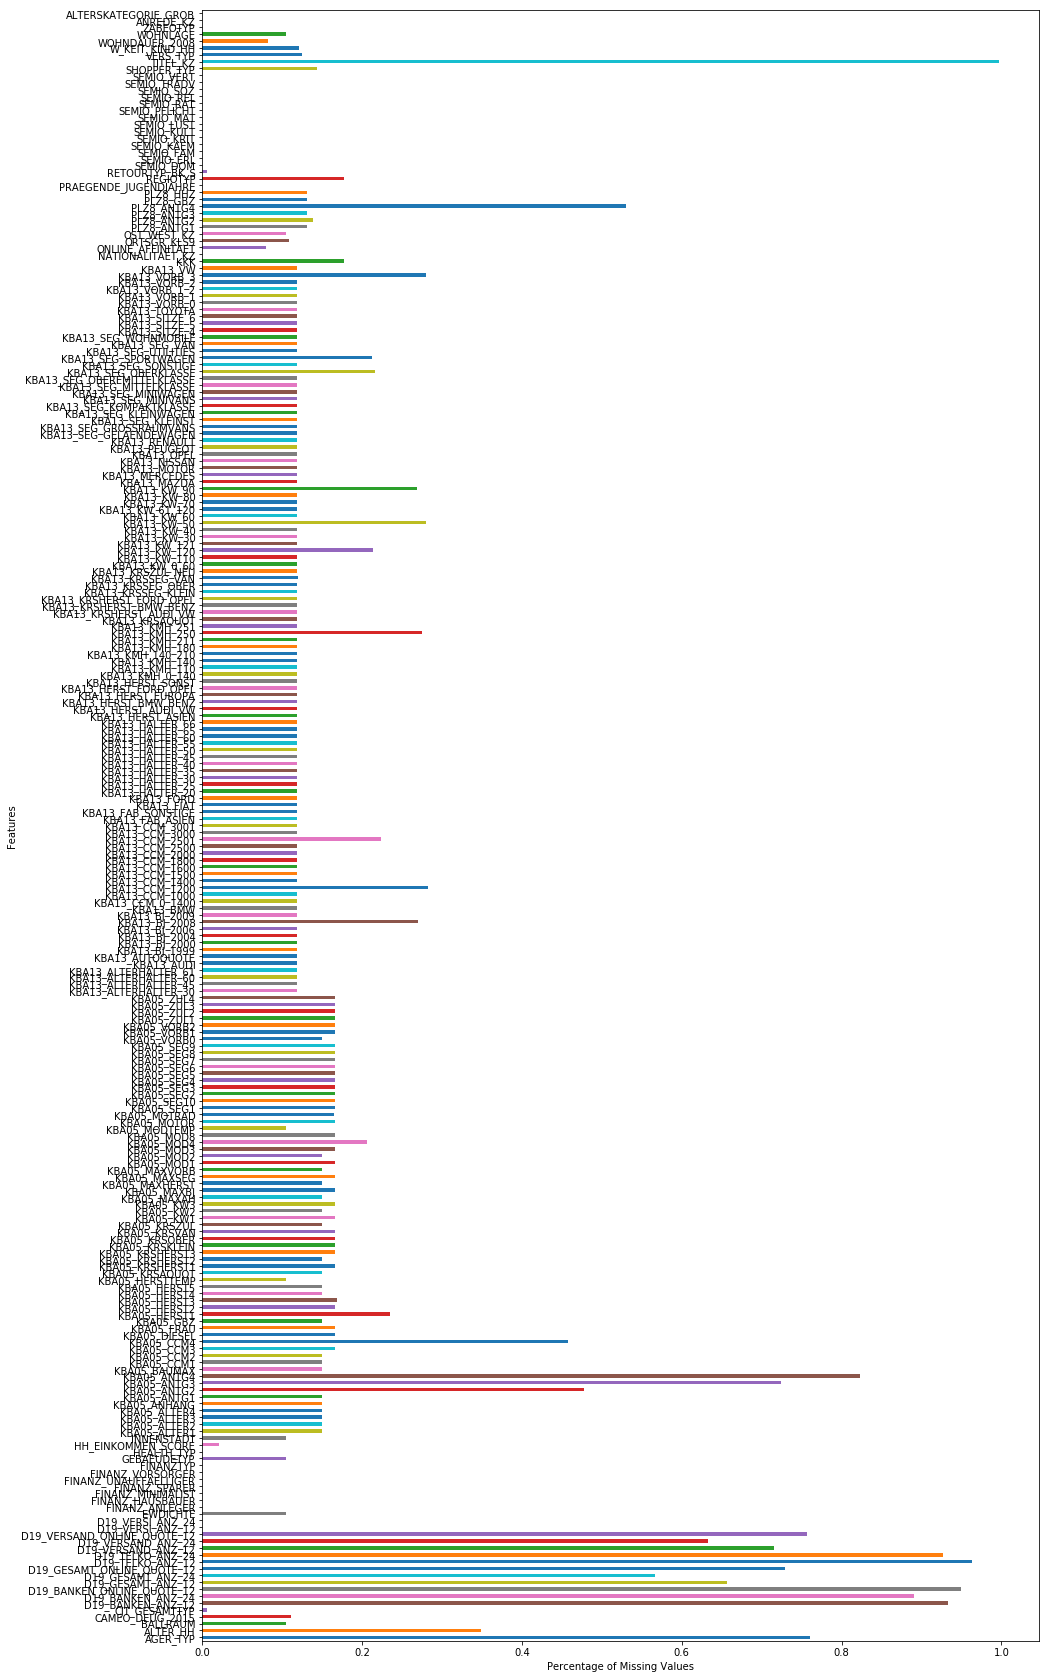

In [21]:
missing_data = pd.Series(azdias.isnull().sum() / len(azdias))

missing_data.plot.barh(figsize=(15,30))
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')

plt.show()

In [22]:
missing_data_columns = missing_data[missing_data > 0.2].index.tolist()

In [23]:
print(missing_data_columns)

['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_CCM4', 'KBA05_HERST1', 'KBA05_MOD4', 'KBA13_BJ_2008', 'KBA13_CCM_1200', 'KBA13_CCM_2501', 'KBA13_KMH_250', 'KBA13_KW_120', 'KBA13_KW_50', 'KBA13_KW_90', 'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_VORB_3', 'PLZ8_ANTG4', 'TITEL_KZ']


In [26]:
azdias.info()

AttributeError: 'NoneType' object has no attribute 'info'

In [24]:
azdias_subset = azdias.drop(missing_data_columns,axis=1)

In [25]:
missing_data = pd.Series(azdias_subset.isnull().sum() / len(azdias_subset))

missing_data.plot.barh(figsize=(15,30))
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')

plt.show()

AttributeError: 'NoneType' object has no attribute 'isnull'

#### Discussion 1.1.2: Assess Missing Data in Each Column

Columns with more than 30% of missing values got dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

In [ ]:
# How much data is missing in each row of the dataset?

missing_data_rows = azdias.isnull().sum(axis=1)

plt.figure(figsize=(15,8))
ax = sns.countplot(missing_data_rows)
ax.set_xlabel('Missing Data in Rows')
ax.set_ylabel('Number of Rows')
plt.show()


In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias['NaN_count'] = azdias.isnull().sum(axis=1)
missing_data_rows_below = azdias.query('NaN_count < 10')
missing_data_rows_below = missing_data_rows_below.drop('NaN_count',axis=1)
missing_data_rows_above = azdias.query('NaN_count >= 10')
missing_data_rows_above = missing_data_rows_above.drop('NaN_count',axis=1)

In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

no_missing_values = list(azdias.query('NaN_count == 0'))
random.seed(60)
random_column = random.sample(no_missing_values, 5)


def counterplot(random_column, below, above):
    plt.figure(figsize=(15,27))
    for i, column in enumerate(random_column):
        plt.subplot(5, 2, i*2 + 1)
        sns.countplot(x=column, data=below)
        plt.subplot(5, 2, i*2 + 2)
        sns.countplot(x=column, data=above)
        plt.tight_layout()

counterplot(random_column, missing_data_rows_below, missing_data_rows_above)

#### Discussion 1.1.3: Assess Missing Data in Each Row

For'ZABEOTYP', 'SHOPPER_TYP', 'SEMIO_KARM', the distributions for these columns are quite different between many and few missing values.

For 'PLZ8_BAUMAX', 'NATIONALITAET_KZ', the distributions for these columns are almost the same between many and few missing values.

So I will use the dataset with few missing values for further analysis.

### Step 1.2: Select and Re-Encode Features

In [ ]:
feat_info.set_index('attribute', inplace=True)

In [ ]:
feat_info.head()

In [ ]:
# How many features are there of each data type?

datatype = []

for each in missing_data_rows_below.columns:
    d = feat_info.loc[each].type
    datatype.append(d)

Counter(datatype)

#### Step 1.2.1: Re-Encode Categorical Features

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

print('Binary Categorical variables:')
print(' ')

for each in missing_data_rows_below.columns:                                             
        
    if feat_info.loc[each].type == 'categorical' and len(missing_data_rows_below[each].unique()) == 2:
        print(each)
#         print(each + ' ' + feat_info.loc[each].type)
#         print(missing_data_rows_below[each].unique())

print(' ')        
print(' ')        
print('Multi-level Categorical variables:')
print(' ')

multi_level = []

for each in missing_data_rows_below.columns:                                             
        
    if feat_info.loc[each].type == 'categorical' and len(missing_data_rows_below[each].unique()) > 2:
        print(each)
        multi_level.append(each)
#         print(each + ' ' + feat_info.loc[each].type)
#         print(missing_data_rows_below[each].unique())

print(' ')        
print(' ')        
print('Mixed Categorical variables:')
print(' ')



for each in missing_data_rows_below.columns:                                             
        
    if feat_info.loc[each].type == 'mixed':
        print(each)
#         print(each + ' ' + feat_info.loc[each].type)
#         print(missing_data_rows_below[each].unique())
        


In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.

missing_data_rows_below.drop(multi_level, axis=1, inplace=True)

missing_data_rows_below = pd.get_dummies(data=missing_data_rows_below, columns=['OST_WEST_KZ','ANREDE_KZ'])

missing_data_rows_below.drop(['OST_WEST_KZ_W'], axis=1, inplace=True)

missing_data_rows_below.drop(['ANREDE_KZ_2.0'], axis=1, inplace=True)

missing_data_rows_below.head()

#### Discussion 1.2.1: Re-Encode Categorical Features

For Multi-level Categorical variables, they will be dropped for further analysis.

The variable 'OST_WEST_KZ' needs be to re-encoded since it takes on non-numeric values. After using pd.get_dummies, two new columns get generated. So I dropped column 'OST_WEST_KZ_W' since it is redundant.


#### Step 1.2.2: Engineer Mixed-Type Features

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade)

movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement)

azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

missing_data_rows_below.head()

### Step 1.3: Create a Cleaning Function

In [ ]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    df.drop(azdias_missing,axis=1)
    
    feat_info = pd.read_csv('DIAS Attributes - Values 2017_final.csv',delimiter=',')
    
    feat_info.set_index('attribute', inplace=True)
    
    feat_info.drop(feat_info_missing, inplace=True)
    
    feat_info.reset_index(inplace=True)
    
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

    for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_or_unknown[0] == '':
            df[attribute] = df[attribute].replace('',np.nan)
  
        elif len(missing_or_unknown) > 1:
            for each in missing_or_unknown:
                each = int(each)
                df.loc[df[attribute] == each, [attribute]] = np.nan
        else:
            for each in missing_or_unknown:
                each = int(each)
                df.loc[df[attribute] == each, [attribute]] = np.nan
                
                
    missing_data = pd.Series(df.isnull().sum() / len(df))
    
    missing_data_columns = missing_data[missing_data > 0.3].index.tolist()
          
    df_clean = df.drop(missing_data_columns,axis=1)    
                
    df_clean['NaN_count'] = df_clean.isnull().sum(axis=1)
    missing_data_rows_below = df_clean.query('NaN_count < 10')
    missing_data_rows_below = missing_data_rows_below.drop('NaN_count',axis=1)
    
    multi_level = []

    for each in missing_data_rows_below.columns:
        if feat_info.loc[each].type == 'categorical' and len(missing_data_rows_below[each].unique()) > 2:
            multi_level.append(each)
    
    missing_data_rows_below.drop(multi_level, axis=1, inplace=True)

    missing_data_rows_below = pd.get_dummies(data=missing_data_rows_below, columns=['OST_WEST_KZ','ANREDE_KZ'])
    
    missing_data_rows_below.drop(['OST_WEST_KZ_W'], axis=1, inplace=True)
    
    missing_data_rows_below.drop(['ANREDE_KZ_2.0'], axis=1, inplace=True)

    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade)

    movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)

    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

        
    return missing_data_rows_below
  
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

missing_data_rows_below.isnull().values.any()

In [ ]:
for each in missing_data_rows_below.columns:
    missing_data_rows_below[each] = missing_data_rows_below[each].fillna(missing_data_rows_below[each].mode()[0])
    
missing_data_rows_below.isnull().values.any()

In [ ]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
missing_data_rows_below[missing_data_rows_below.columns] = scaler.fit_transform(missing_data_rows_below[missing_data_rows_below.columns])

missing_data_rows_below.head()

### Discussion 2.1: Apply Feature Scaling

The null values have been imputed with mode values from the dataset. The whole dataset has been normalized using StandardScaler module from scikit learn library.

### Step 2.2: Perform Dimensionality Reduction

In [ ]:
# Apply PCA to the data.

pca = PCA()
missing_data_rows_below_pca = pca.fit_transform(missing_data_rows_below)

In [ ]:
# Investigate the variance accounted for by each principal component.

def screen_plot(pca):
    '''
    Creates a scree plot associated with the principal components 

    INPUT: pca - the result of instantian of PCA in scikit learn

    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explain （%)")
    plt.title('Explained Variance Per Principal Component')
    
screen_plot(pca)

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=100)
missing_data_rows_below_pca = pca.fit_transform(missing_data_rows_below)
screen_plot(pca)

In [ ]:
# Calculate the total variance ratio
pca.explained_variance_ratio_.sum()

### Discussion 2.2: Perform Dimensionality Reduction



Based on the total variance ratio, 84% of total variance can be explained by 25 components. So I will use 25 components for Dimensionality Reduction Analysis.



### Step 2.3: Interpret Principal Components

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(data, pca, comp):
    
    feature = data.columns.tolist()
    component = pca.components_[comp].tolist()
    feature_weight = pd.DataFrame(list(zip(feature, component)))
    feature_weight.set_axis(['Feature', 'Weight'], axis=1, inplace=True)
    feature_weight = feature_weight.sort_values(by=['Weight'] , ascending=False)
    
    return feature_weight

first_component = pca_results(missing_data_rows_below, pca, 1)
print(first_component.head())
print(first_component.tail())

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_component = pca_results(missing_data_rows_below, pca, 2)
print(second_component.head())
print(second_component.tail())

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third_component = pca_results(missing_data_rows_below, pca, 3)
print(third_component.head())
print(third_component.tail())

### Discussion 2.3: Interpret Principal Components

Each weight has been mapped to their corresponding feature name. Also the features have been sorted according to their weight. Based on the weight value in these three components, I will pick 0.25 as the level of importance for the correlation.

<br>

The first principle component is strongly correlated with two of the original features: 'ALTERSKATEGORIE_GROB' and 'SEMIO_REL'.
It increases with increasing in 'ALTERSKATEGORIE_GROB' and decreasing in 'SEMIO_REL'. For 'ALTERSKATEGORIE_GROB'(age), it is from 1 to 4, 1 being youngest. For 'SEMIO_REL'(religious affinity), it is from 1 to 7, 1 being the highest.
This component describes the group with older people have high affinity in religion.

<br>
<br>

The second principle component is strongly correlated with these features: 'SEMIO_VERT','SEMIO_SOZ','SEMIO_KRIT','SEMIO_DOM','SEMIO_KAEM','ANREDE_KZ'. It increases with increasing in ('SEMIO_VERT','SEMIO_SOZ') and decreasing in ('SEMIO_KRIT','SEMIO_DOM','SEMIO_KAEM','ANREDE_KZ').

For 'SEMIO_VERT'(dreamful), it is from 1 to 7, 1 being the highest.

For 'SEMIO_SOZ'(socially-minded), it is from 1 to 7, 1 being the highest.

For 'SEMIO_KRIT'(critical-minded), it is from 1 to 7, 1 being the highest.

For 'SEMIO_DOM'(dominant-minded), it is from 1 to 7, 1 being the highest.

For 'SEMIO_KAEM'(combative attitude), it is from 1 to 7, 1 being the highest.

For 'ANREDE_KZ'(gender), 1 is male and 2 is female.

This component describes the group with males who are less dreamful and socially-minded, but more critical, dominant, and combative-minded.

<br>
<br>
<br>
<br>

In the third principle component, is strong correlated with these features: 'GREEN_AVANTGARDE', 'EWDICHTE', 'ORTSGR_KLS9', 'REGIOTYP', 'BALLRAUM', 'HH_EINKOMMEN_SCORE', 'KKK'. It increases with increasing in ( 'GREEN_AVANTGARDE', 'EWDICHTE', 'ORTSGR_KLS9') and decreasing in ('REGIOTYP', 'BALLRAUM', 'HH_EINKOMMEN_SCORE', 'KKK').

For 'GREEN_AVANTGARDE'(Membership in environmental sustainability), 0 is nonmember, 1 is member.

For 'EWDICHTE'(Density of households), it is from 1 to 6, 6 being the highest.

For 'ORTSGR_KLS9'(Size of community), it is from 1 to 9, 9 being the highest.

For 'REGIOTYP'(Neighborhood typology), it is from 1 to 7, 1 being the highest.

For 'BALLRAUM'(Distance to nearest urban center), it is from 1 to 7, 7 being the highest.

For 'HH_EINKOMMEN_SCORE'(Estimated household net income), it is from 1 to 6, 1 being the highest.

For 'KKK'(Purchasing power in region), it is from 1 to 4, 1 being the highest.

This component describes the group with people with membership in environmental sustainability. They lives in area with high density of households and large commnunity. The neighborhood tends to be upper class. The distance to neareset urban center is low. They have high income and more purchasing power in the region.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [ ]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    

def get_kmeans_score(data, center):
    
    kmeans = KMeans(n_clusters=center)
    
    model = kmeans.fit(data)
    
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,25,2))

for center in centers:
    scores.append(get_kmeans_score(missing_data_rows_below_pca, center))
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model = KMeans(n_clusters=15).fit(missing_data_rows_below_pca)

general_prediction = model.predict(missing_data_rows_below_pca)

### Discussion 3.1: Apply Clustering to General Population


Based on the plot,  I picked '15' for the number of clusters using elbow method. The rate of change at 15 tends to decrease.

### Step 3.2: Apply All Steps to the Customer Data

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_new = clean_data(customer)

for each in customer_new.columns:
    customer_new[each] = customer_new[each].fillna(customer_new[each].mode()[0])
    
customer_new.isnull().values.any()

In [ ]:
customer_new[customer_new.columns] = scaler.transform(customer_new[customer_new.columns])

customer_new_pca = pca.transform(customer_new)

customer_prediction = model.predict(customer_new_pca)

### Step 3.3: Compare Customer Data to Demographics Data

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_population = []
customer_population = []
cluster = []

for i in range(15):
    general_population.append((general_prediction == i).sum()/len(general_prediction))
    customer_population.append((customer_prediction == i).sum()/len(customer_prediction))
    cluster.append(i+1)

d = {'Cluster_Num' : cluster, 'General_Population' : general_population, 'Customer_Population':customer_population}    

df_proportion = pd.DataFrame(data=d)
df_proportion.plot(x='Cluster_Num', kind='bar', figsize=(14,8))

plt.ylabel('Proportion For Clusters')
plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over_inverse = scaler.inverse_transform(pca.inverse_transform(customer_new_pca[np.where(customer_prediction==13)]))
df_over = pd.DataFrame(data=over_inverse,columns=customer_new.columns)

df_over.head()

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

under_inverse = scaler.inverse_transform(pca.inverse_transform(customer_new_pca[np.where(customer_prediction==8)]))
df_under = pd.DataFrame(data=under_inverse,columns=customer_new.columns)

df_under.head()

### Discussion 3.3: Compare Customer Data to Demographics Data


Based on the bar chart, Cluster 13 is the one that is overrepresented in the customer data compared to the general population. People in this cluster should be the target audience for the company. It looks like that the people in this group are older male who lives in large community with upper class neighborhood. They have higher imcome and more purchasing power.

Cluster 8 is the one is underrepresented in the customer data compared to the general population. The people in this group should be outside of the target demographics. The people in this group are more likely to be young female who are dreamful and social-minded. They are less-critical and dominant minded and have lower financial status.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.head()

In [ ]:
mailout_train_clean = clean_data(mailout_train)

In [ ]:
# Total number of records
n_records = mailout_train.shape[0]

# Number of records where the individual became a customer
n_customer = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]

# Number of records where individual did not become a customer
n_not_customer = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who became customers
customer_perc = (n_customer / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals who became customers: {}".format(n_customer))
print("Individuals who did not become customers: {}".format(n_not_customer))
print("Percentage of individuals who became customers: {}%".format(customer_perc))

In [ ]:
# Split the data into features and target label
response_raw = mailout_train['RESPONSE']
features_raw = mailout_train.drop('RESPONSE', axis = 1)

In [ ]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=28)
skf.get_n_splits(features_raw, response_raw)
print(skf)

In [ ]:
clf_A = AdaBoostClassifier(random_state=28)
clf_B = GradientBoostingClassifier(random_state=28)
clf_C = RandomForestClassifier(random_state=28)

In [ ]:
model_scores = {}

for i, clf in enumerate([clf_A, clf_B, clf_C]):

    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])

    scores = []
    j = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(features_raw, response_raw):
        j+=1
        print('Classifier {}: Fold {}...'.format(i+1, j))
        
        # Split the data into training and test sets
        X_train, X_test = features_raw.iloc[train_index], features_raw.iloc[test_index]
        y_train, y_test = response_raw.iloc[train_index], response_raw.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print(score)

    model_scores[clf] = scores

In [ ]:
scores_df = pd.DataFrame(model_scores)
scores_df.columns = ['AdaBoostRegressor', 'GradientBoostingRegressor', 'RandomForestClassifier']
scores_df

In [ ]:
scores_df.describe()

In [ ]:
# Create function to make a machine learning pipeline

def create_pipeline(clf):
    
    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])
    
    return pipeline

In [ ]:
# Create function to do 5-fold cross-validation above

def cross_validate(clf):

    pipeline = create_pipeline(clf)
    scores = []
    i = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(features_raw, response_raw):
        i+=1
        print('Fold {}'.format(i))
        
        # Split the data into training and test sets
        X_train, X_test = features_raw.iloc[train_index], features_raw.iloc[test_index]
        y_train, y_test = response_raw.iloc[train_index], response_raw.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print("Score: {}".format(score))
        
    return scores

In [ ]:
# Create initial model
clf_0 = XGBRegressor(
    objective = 'binary:logistic', #logistic regression for binary classification
    scale_pos_weight = 1, #because of high class imbalance
    random_state = 28)

In [ ]:
tuned_scores0 = cross_validate(clf_0)

In [ ]:
# Save to file in the current working directory
pkl_filename = "best_gradient_boosting.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)

In [ ]:
feature_importances = best_clf.named_steps['classifier'].feature_importances_
pd.Series(feature_importances, index=column_names).sort_values()[-40:].plot(kind='barh', figsize=(7,10))
plt.xlabel('feature importance')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.info()

In [ ]:
mailout_test_clean = clean_data(mailout_test)

In [ ]:
mailout_test_cleaned = mailout_test_cleaned[mailout_train_cleaned.drop(["RESPONSE"], axis=1).columns]

In [ ]:
pkl_filename = "best_gradient_boosting.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file) 
    
#predict target values
kaggle_predict = pickle_model.predict_proba(mailout_test_cleaned)[:,1]
kaggle_predict

In [ ]:
submission = pd.read_csv('../Arvato-Capstone/Arvato_Capstone_Example_Submission.csv')
submission.RESPONSE = kaggle_predict
submission.to_csv('kaggle_submission.csv', index=False)
submission.shape

In [ ]:
submission.columns